In [50]:
import numpy as np
import pandas as pd

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [51]:
main_dir = "/kaggle/input/utkface-new/crop_part1"

In [52]:
path_arr = []
age_arr = []

for file in tqdm(os.listdir(main_dir)):
    labels = file.split("_")
    
    filepath = os.path.join(main_dir, file)
    age = int(labels[0])
    
    path_arr.append(filepath)
    age_arr.append(age)

100%|██████████| 9780/9780 [00:00<00:00, 272283.28it/s]


In [53]:
df = pd.DataFrame({
    "image_path": path_arr,
    "age": age_arr,
})

In [54]:
df.head(10)

,image_path,age
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26
1,/kaggle/input/utkface-new/crop_part1/21_1_3_20...,21
2,/kaggle/input/utkface-new/crop_part1/17_1_4_20...,17
3,/kaggle/input/utkface-new/crop_part1/76_0_0_20...,76
4,/kaggle/input/utkface-new/crop_part1/18_1_0_20...,18
5,/kaggle/input/utkface-new/crop_part1/12_1_0_20...,12
6,/kaggle/input/utkface-new/crop_part1/4_0_0_201...,4
7,/kaggle/input/utkface-new/crop_part1/67_0_0_20...,67
8,/kaggle/input/utkface-new/crop_part1/26_1_2_20...,26
9,/kaggle/input/utkface-new/crop_part1/90_0_2_20...,90


In [55]:
TRAIN, VALID, TEST = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

TRAIN = TRAIN.reset_index(drop=True)
VALID = VALID.reset_index(drop=True)
TEST = TEST.reset_index(drop=True)

print("Total shape:", df.shape[0])
print("Shape of trainset:", TRAIN.shape[0])
print("Shape of Validation set:", VALID.shape[0])
print("Shape of testset:", TEST.shape[0])

Total shape: 9780
Shape of trainset: 5868
Shape of Validation set: 1956
Shape of testset: 1956


## Data Visualization

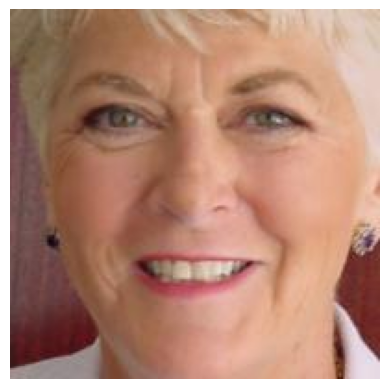

In [56]:
from PIL import Image
img=Image.open(df['image_path'][10])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

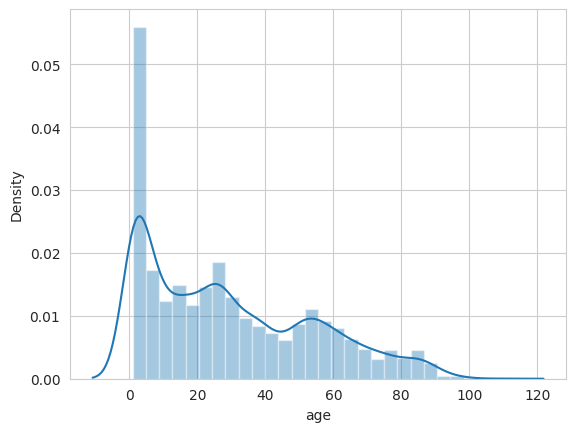

In [57]:
sns.distplot(df['age'])

In [58]:
train_img_arr = []
train_age_arr = []

for idx, row in tqdm(TRAIN.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    train_img_arr.append(img)
    train_age_arr.append(row['age'])
    
train_img_arr = np.array(train_img_arr).reshape(len(train_img_arr), 128, 128, 1)
train_age_arr = np.array(train_age_arr)

5868it [00:16, 366.63it/s]


In [59]:
valid_img_arr = []
valid_gender_arr = []
valid_age_arr = []

for idx, row in tqdm(VALID.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    valid_img_arr.append(img)
    valid_age_arr.append(row['age'])
    
valid_img_arr = np.array(valid_img_arr).reshape(len(valid_img_arr), 128, 128, 1)
valid_age_arr = np.array(valid_age_arr)

1956it [00:05, 357.01it/s]


In [60]:
test_img_arr = []
test_gender_arr = []
test_age_arr = []

for idx, row in tqdm(TEST.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    test_img_arr.append(img)
    test_age_arr.append(row['age'])
    
test_img_arr = np.array(test_img_arr).reshape(len(test_img_arr), 128, 128, 1)
test_age_arr = np.array(test_age_arr)

1956it [00:05, 362.66it/s]


## Model Initiation

In [61]:
inputs = Input(shape=(128, 128, 1))

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max1)
max2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max2)
max3 = MaxPooling2D(pool_size=(2, 2))(conv3)

flat = Flatten()(max3)

dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(0.3)(dense1)
output_age = Dense(1, activation='relu')(drop1)

model = Model(inputs=[inputs], outputs=[output_age])

model.compile(loss='mae',
              optimizer='adam',
              metrics=['mae'])

In [62]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,515,713 (24.86 MB)

 Trainable params: 6,515,713 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

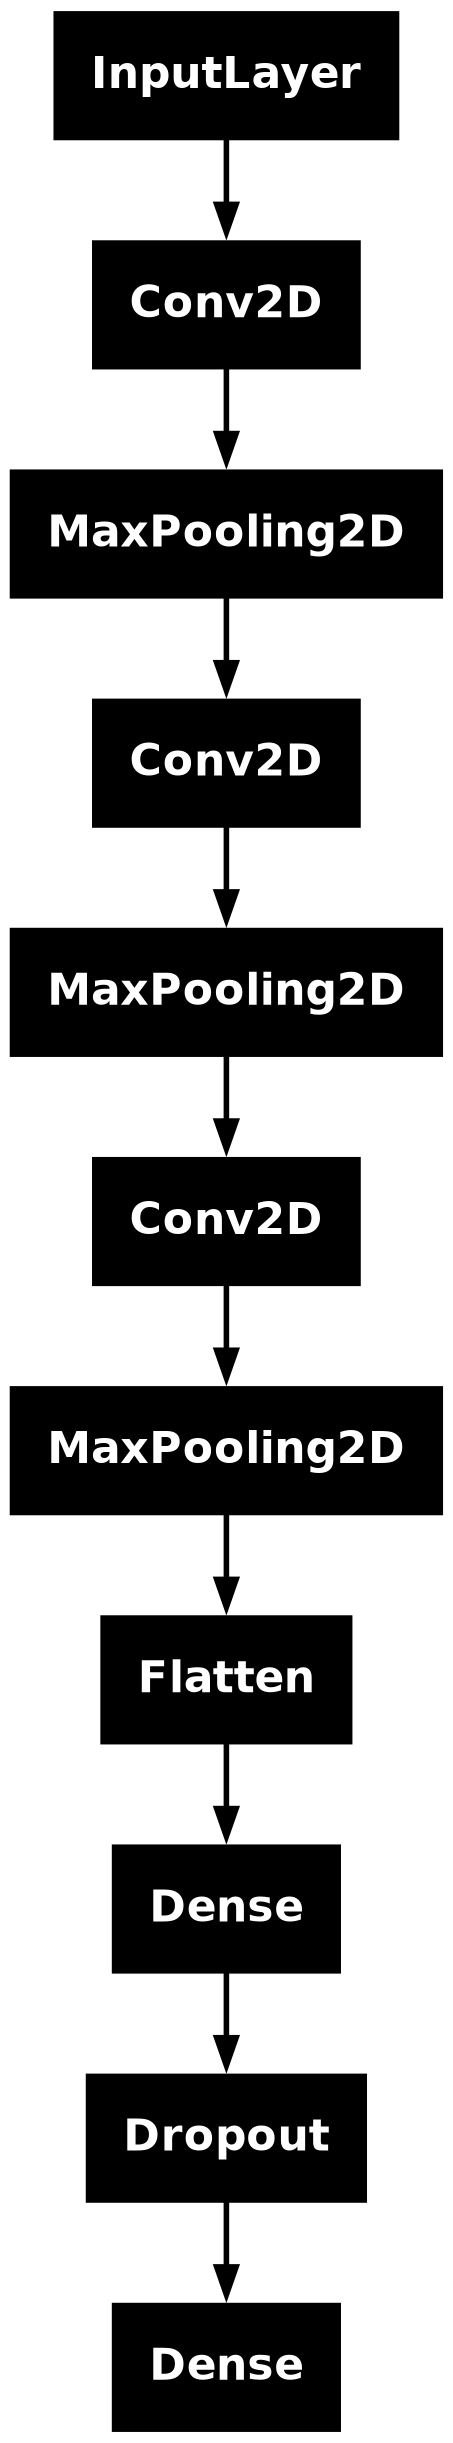

In [63]:
plot_model(model)

In [64]:
history = model.fit(x=train_img_arr, y=[train_age_arr], batch_size=64, epochs=25, validation_data=(valid_img_arr, [valid_age_arr]))

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 22.2388 - mae: 22.2388 - val_loss: 16.3086 - val_mae: 16.3086
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 13.7731 - mae: 13.7731 - val_loss: 13.1751 - val_mae: 13.1751
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.0666 - mae: 12.0666 - val_loss: 13.5674 - val_mae: 13.5674
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 11.6454 - mae: 11.6454 - val_loss: 11.0424 - val_mae: 11.0424
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 10.1611 - mae: 10.1611 - val_loss: 10.6718 - val_mae: 10.6718
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.4938 - mae: 9.4938 - val_loss: 8.8903 - val_mae: 8.8903
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.1410 - mae: 9.1410 - val_loss: 11.0828 - val_mae: 11.0828
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.5307 - mae: 8.5307 - val_loss: 15.5449 - val_mae: 15.5449
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s

In [65]:
# history = model.fit(x=train_img_arr, y=[train_age_arr], 
#                     epochs=10, 
#                     batch_size=32, 
#                     validation_data=(valid_img_arr, [valid_age_arr]), 
#                     verbose=1)

## Plotting Results

In [66]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mae,val_loss,val_mae
0,19.561062,19.561062,16.308619,16.308619
1,13.069502,13.069502,13.175089,13.175089
2,11.658301,11.658301,13.567445,13.567445
3,11.332072,11.332072,11.042434,11.042434
4,9.887400,9.887400,10.671821,10.671821


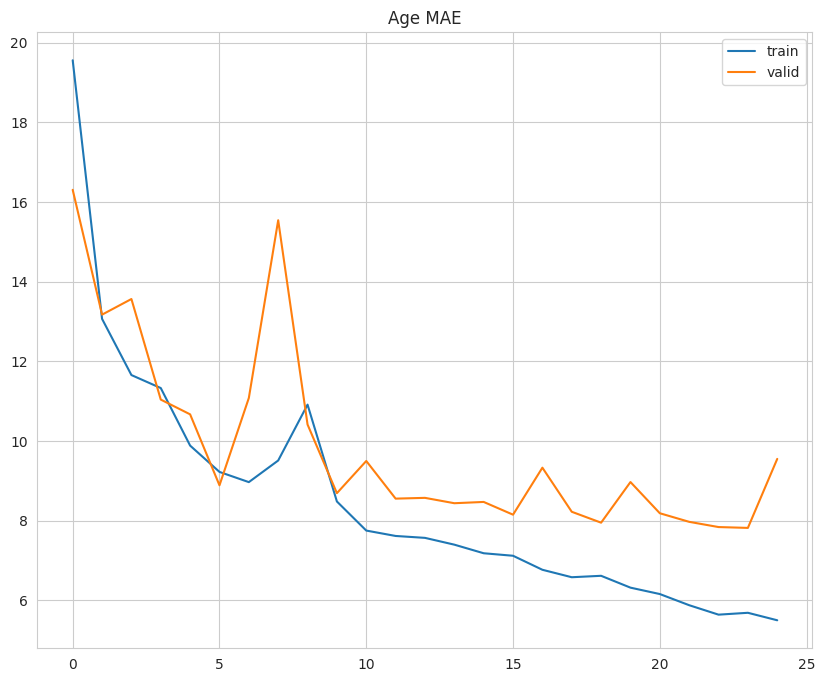

In [67]:
if "mae" in history_df.columns and "val_mae" in history_df.columns:
    plt.figure(figsize=(10, 8))
    plt.title("Age MAE")
    plt.plot(history_df["mae"])
    plt.plot(history_df["val_mae"])
    plt.legend(["train", "valid"])
    plt.show()
else:
    print("Error: Columns 'mae' and/or 'val_mae' do not exist in the DataFrame.")

## Model's performance on Testset

In [68]:
preds = model.predict(test_img_arr, verbose=0)
pred_age = np.round(preds).flatten().tolist()

In [69]:
TEST["pred_age"] = pred_age

In [70]:
TEST.head()

,image_path,age,pred_age
0,/kaggle/input/utkface-new/crop_part1/21_1_4_20...,21,67.0
1,/kaggle/input/utkface-new/crop_part1/80_0_2_20...,80,64.0
2,/kaggle/input/utkface-new/crop_part1/59_0_0_20...,59,77.0
3,/kaggle/input/utkface-new/crop_part1/77_0_0_20...,77,78.0
4,/kaggle/input/utkface-new/crop_part1/17_1_0_20...,17,29.0


In [71]:
def visualize_age_results(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            img_age = df.loc[a][['age']].values[0]
            img_pred_age = df.loc[a][['pred_age']].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Pred Age: {img_pred_age}(True:{img_age})")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

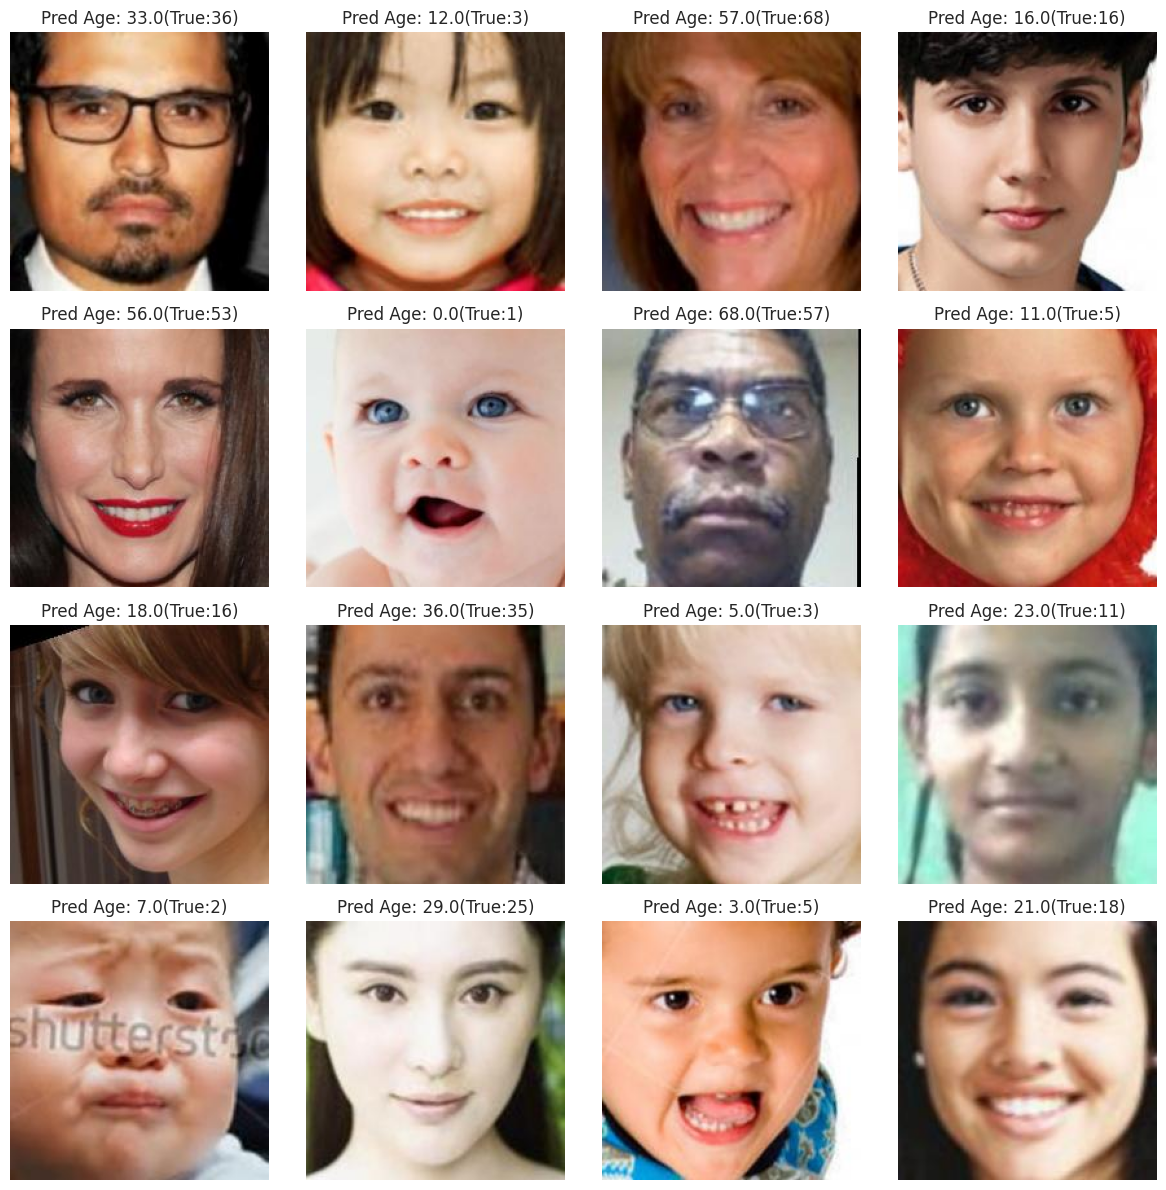

In [73]:
visualize_age_results(TEST)

In [74]:
import tensorflow as tf

model.save('Age_Detection_Model_v1.0.h5')